In [1]:
import scipy
import torch
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm


import sys
sys.path.append("../")

from models import RNNGC
from dataset import DatasetMaker
plt.style.use("../project_style.mplstyle")

from review_utils import LinearDecoder, decode

In [2]:
# instantiate RNN model

model = RNNGC()
model = model.load("../saved-models/RNNGC_49999.pkl")

In [3]:
bs = 64
timesteps = 10
train_steps = 50000

decoder = LinearDecoder(model.ng, 2)
optimizer = torch.optim.Adam(decoder.parameters(), lr = 1e-3)

In [4]:
dataset = DatasetMaker()

In [5]:
loss_history = []
for i in tqdm(range(train_steps)):
    r, v = dataset.generate_data(bs, timesteps)
    # r = r - r[:,0,None]
    g = model((r[:,0], v))
    loss = decoder.train_step(torch.cat((g[:,1:], r[:,:-1]),dim=-1), r[:,1:], optimizer = optimizer)
    loss_history.append(loss)

100%|██████████| 50000/50000 [02:41<00:00, 309.97it/s]


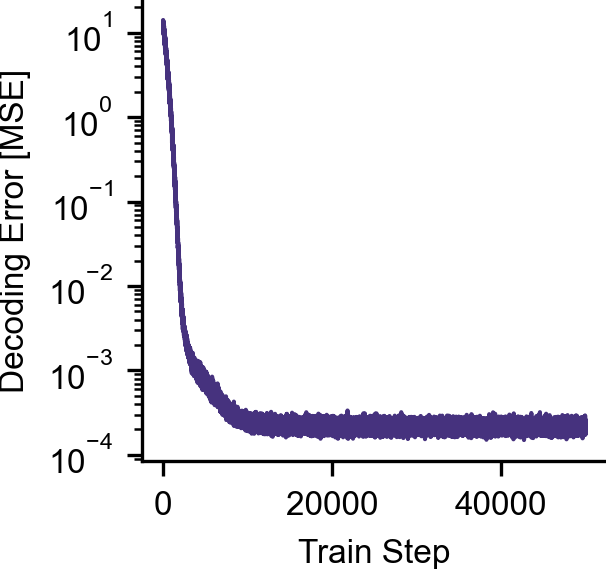

In [22]:
plt.figure(figsize=(2,2))
plt.semilogy(loss_history)
plt.xlabel("Train Step")
plt.ylabel("Decoding Error [MSE]")
plt.savefig("./review_figs/decoder_train_history")

In [13]:
eval_dataset = DatasetMaker()
# evaluate on fresh data
t_eval = 500
r_eval, v_eval = eval_dataset.generate_data(1000, t_eval)
r_eval = r_eval - r_eval[:,0,None]
g_eval = model((r_eval[:,0], v_eval))

In [14]:
# r_pred = torch.zeros(r_eval.shape)

# for i in range(t_eval-1):
#     r_pred[:,i+1] = decoder(torch.cat((g_eval[:,i+1], r_pred[:,i]),dim=-1))

r_pred = decode(g_eval, decoder, r0 = torch.zeros((g_eval.shape[0], 2)))

In [15]:
r_decoded = r_pred.detach().numpy()
r_eval = r_eval.detach().numpy()
g_eval = g_eval.detach().numpy()

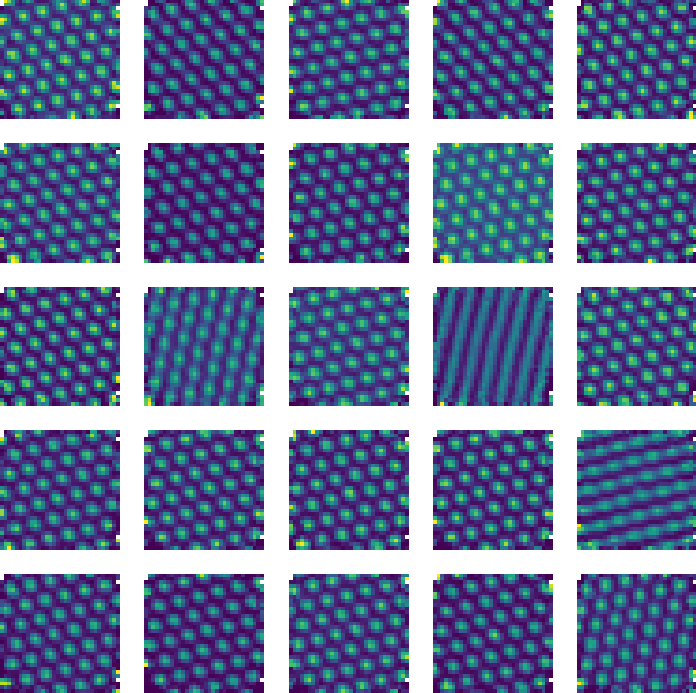

In [16]:
ratemaps = scipy.stats.binned_statistic_2d(r_eval[...,0].ravel(), r_eval[...,1].ravel(), g_eval.reshape(-1, g_eval.shape[-1]).T, bins = 32)[0]

ns = 5 # ns x ns grid of unit ratemaps
count = 0
fig, ax = plt.subplots(ns,ns, figsize = (3,3))
for i in range(ns):
    for j in range(ns):
        im = ax[i,j].imshow(ratemaps[count])
        ax[i,j].axis("off")
        count += 1

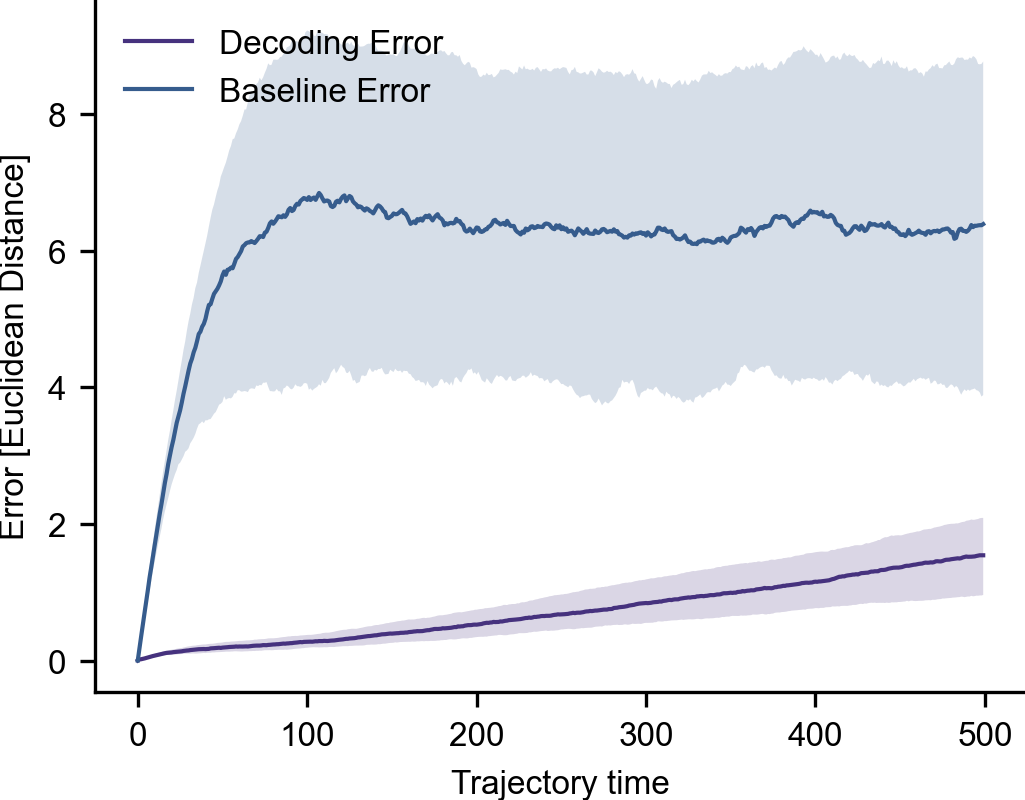

In [19]:
# Compute errors
time_error = np.linalg.norm(r_decoded - r_eval, axis=-1)  # Main error
zero_baseline = np.linalg.norm(r_eval, axis=-1)  # Baseline error

# Compute mean and standard deviation
median_time_error = np.median(time_error, axis=0)
std_time_error = np.std(time_error, axis=0)

median_zero_baseline = np.median(zero_baseline, axis=0)
std_zero_baseline = np.std(zero_baseline, axis=0)

# Plot mean errors with shaded error bands
plt.figure(figsize=(4, 3))

# Main error
plt.plot(median_time_error, label='Decoding Error')
plt.fill_between(
    np.arange(len(median_time_error)),
    np.percentile(time_error, 25,axis=0),
    np.percentile(time_error, 75,axis=0),
    alpha=0.2,
)

# Baseline error
plt.plot(median_zero_baseline, label='Baseline Error')
plt.fill_between(
    np.arange(len(median_zero_baseline)),
     np.percentile(zero_baseline, 25,axis=0),
     np.percentile(zero_baseline, 75,axis=0),
    alpha=0.2,
)
# Add plot labels and legend
plt.xlabel("Trajectory time")
plt.ylabel("Error [Euclidean Distance]")
plt.legend(frameon=False)

plt.savefig("./review_figs/decoding_error")

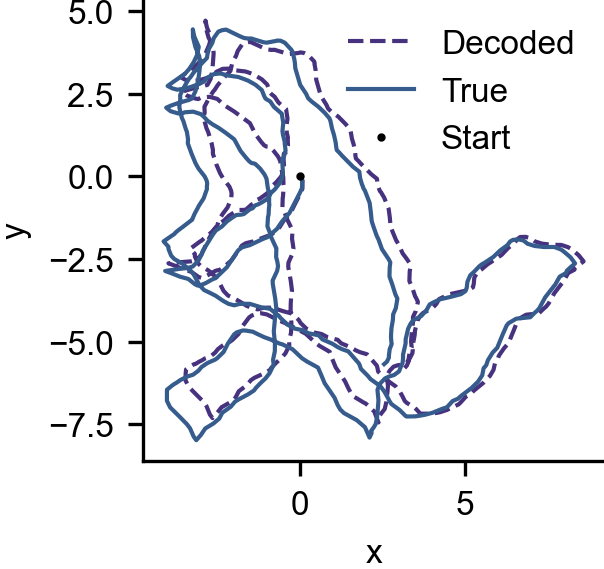

In [21]:
plt.figure(figsize = (2,2))
plt.plot(r_decoded[0,:,0], r_decoded[0,:,1], "--", label = "Decoded")
plt.plot(r_eval[0,:,0], r_eval[0,:,1], label = "True")
plt.plot(r_decoded[0,0,0], r_decoded[0,0,1], "ok", label = "Start")
plt.xlabel("x")
plt.ylabel("y")
plt.legend(frameon = False)
plt.axis("square")
plt.savefig("./review_figs/decoded_trajectory")